In [98]:
import os
import datetime

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow.keras as keras

In [99]:
from SOAI.handler.SOAIDiskHandler import SOAIDiskHandler

Load data - openAir, Lanuv and traffic

In [ ]:
dataOpenAir = pd.read_csv("../data/temp/no2.csv", sep=";")
dataOpenAir["timestamp"] = pd.to_datetime(dataOpenAir["timestamp"])
dataOpenAir = dataOpenAir.set_index("timestamp", drop=True)
dataOpenAir.index = dataOpenAir.index.tz_localize(None)
dataOpenAir = dataOpenAir.drop(columns=["pm10","pm25","r1", "rssi"], axis=1)

dataHandler = SOAIDiskHandler()
dfLanuv = dataHandler.fGetLanuv("../data/lanuv/", selectValidData=True)
dfLanuv.index = dfLanuv.index.tz_localize(None)
dfLanuv.index =  pd.to_datetime(dfLanuv.index, format='%Y-%m-%d %H:%M:%S')

dataTraffic = pd.read_csv("../data/temp/trafficDfLanuv20.csv", sep=",")
dataTraffic = dataTraffic[dataTraffic["inPicture"] == True] 
dataTraffic["date"] = pd.to_datetime(dataTraffic["date"])
dataTraffic = dataTraffic.set_index("date", drop=True)
dataTraffic.index = dataTraffic.index.tz_localize(None)
dataTraffic.index =  pd.to_datetime(dataTraffic.index, format='%Y-%m-%d %H:%M:%S')
dataTraffic = dataTraffic.drop(columns=["Unnamed: 0"], axis=1)

Fill traffic layer with dark green value, if there is no traffic.
We expect the traffic layer to have empty values if there is not enough traffic to measure.  Therefore dark green means no traffic.

In [101]:
dataTraffic["darkGreen"] = dataTraffic.pixelCounterSensor.max() - dataTraffic.pixelCounterSensor

Set traffic in sensor area in relation to all streets on map

In [102]:
dataTraffic["rgreen"] = dataTraffic.apply(lambda x: x["green"] / x["pixelCounterPicture"], axis=1)
dataTraffic["rorange"] = dataTraffic.apply(lambda x: x["orange"] / x["pixelCounterPicture"], axis=1)
dataTraffic["rred"] = dataTraffic.apply(lambda x: x["red"] / x["pixelCounterPicture"], axis=1)
dataTraffic["rbrown"] = dataTraffic.apply(lambda x: x["brown"] / x["pixelCounterPicture"], axis=1)
dataTraffic["rdarkGreen"] = dataTraffic.apply(lambda x: x["darkGreen"] / x["pixelCounterPicture"], axis=1)

Select sensor and reduce dataframes

In [103]:
sensorID = "VKCL" # "VKTU" #"807f8be6"
dataNO2_sensor = dfLanuv[dfLanuv["station"] == sensorID]
dataTraffic_sensor = dataTraffic[dataTraffic["feed"] == sensorID]

Resample data

In [104]:
dataNO2_sensor = dataNO2_sensor.resample("1h").mean()
dataTraffic_sensor = dataTraffic_sensor.resample("1h").mean()

Just keep data that overlaps between no2 dataframe and traffic datafram

In [105]:
timeMin = max(dataNO2_sensor.index.min(), dataTraffic_sensor.index.min())
timeMax = min(dataNO2_sensor.index.max(), dataTraffic_sensor.index.max())

dataNO2_sensor_overlap = dataNO2_sensor.loc[(dataNO2_sensor.index >= timeMin) & (dataNO2_sensor.index <=   timeMax)]
dataTraffic_sensor_overlap = dataTraffic_sensor.loc[(dataTraffic_sensor.index >= timeMin) & (dataTraffic_sensor.index <= timeMax)]

Create plots for no2 dataframe and traffic dataframe (day by day and over all days)

In [106]:
month = 11
days = [20,21,22,23,24,25,26]

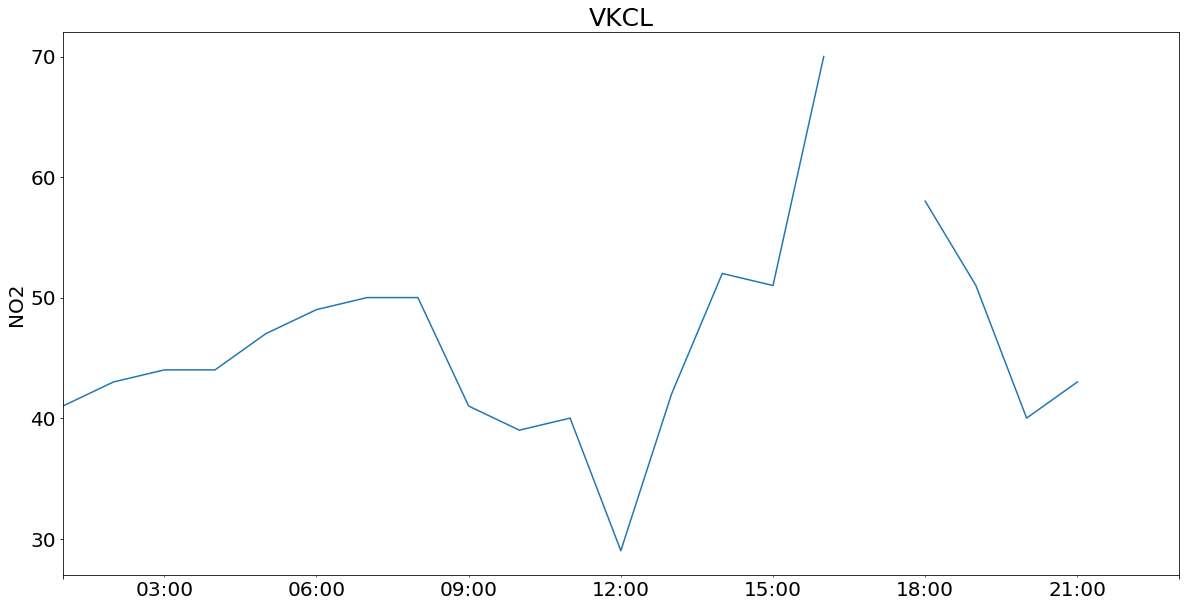

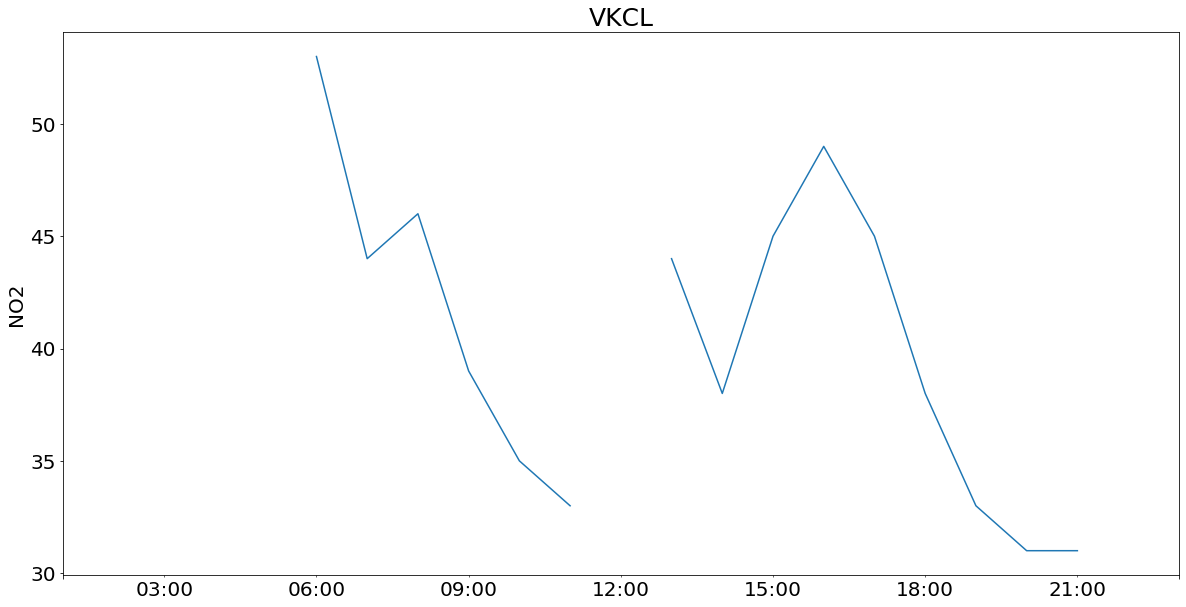

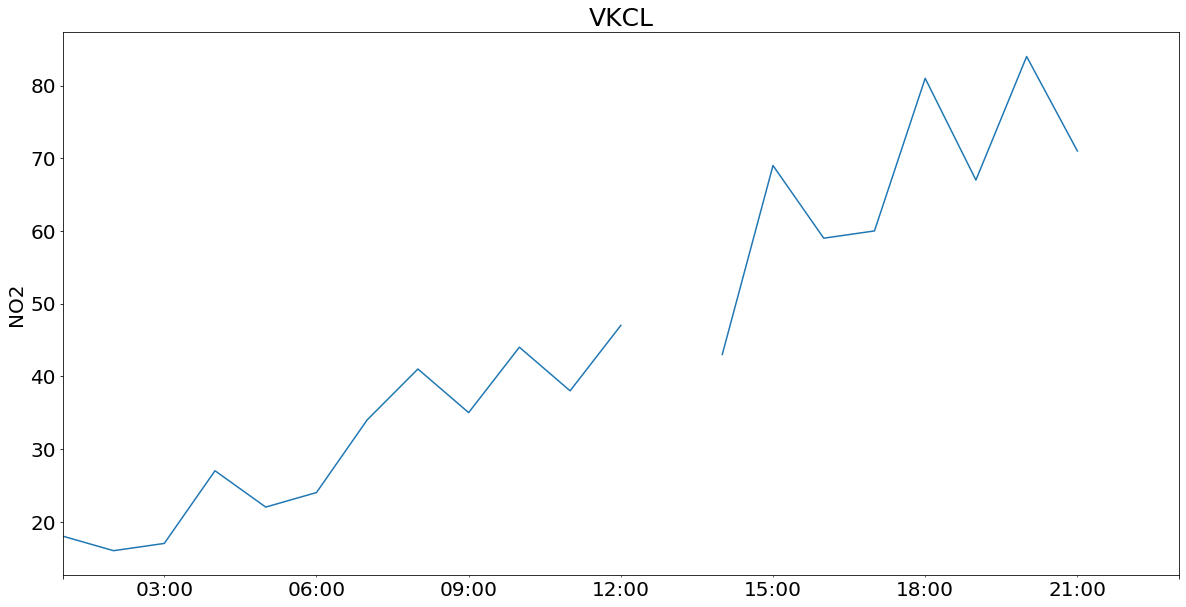

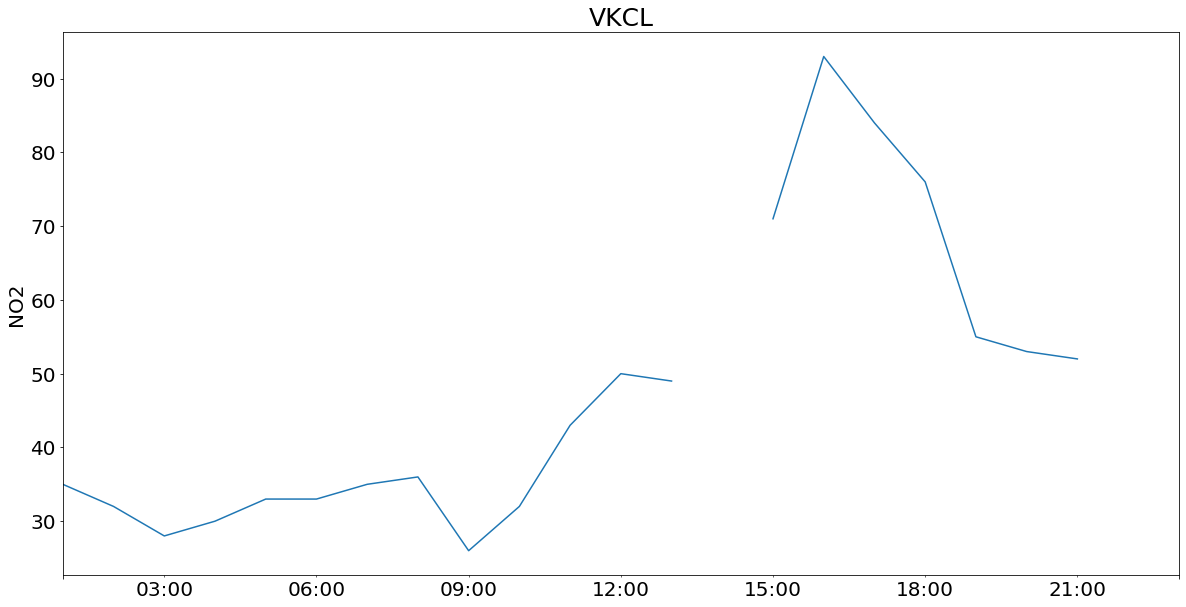

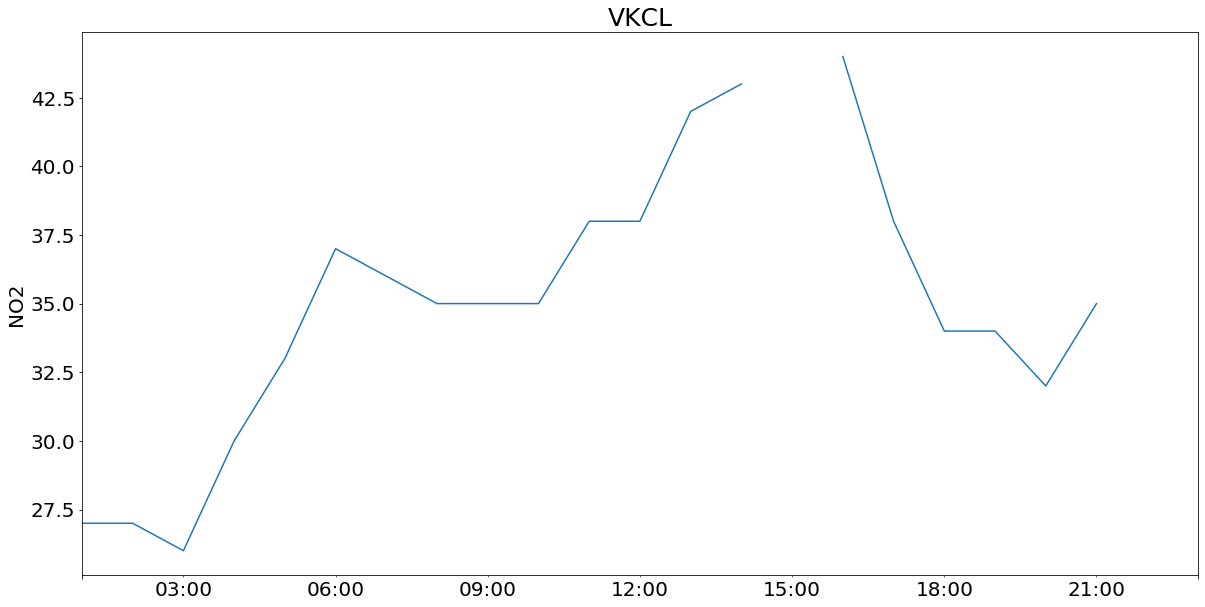

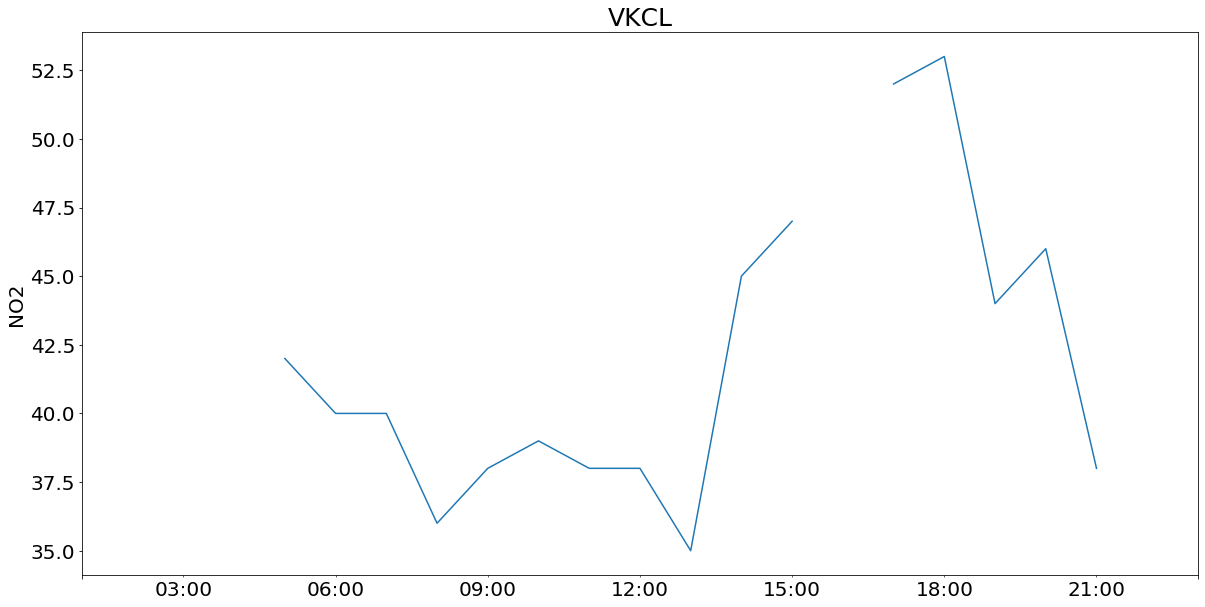

In [107]:
dataNO2CleanPlot = dataNO2_sensor_overlap[(dataNO2_sensor_overlap.index > datetime.datetime(year=2019,month=month,day=days[0])) & \
        (dataNO2_sensor_overlap.index < datetime.datetime(year=2019,month=month,day=days[0]+len(days)))]

fig, ax = plt.subplots()
fig.set_size_inches(20, 10, forward=True)
dataNO2CleanPlot["no2"].plot(figsize=(20,10), fontsize=20, ax=ax)
ax.set_title(sensorID, fontsize=25)
ax.set_ylabel("NO2", fontsize=20)
ax.set_xlabel("")
fig.savefig(f'trafficModelOutput/dataNO2sensorOverlap_{month}_{days[0]}-{days[0]+len(days)}.png')

for n,i in enumerate(days):
    dataNO2CleanPlot = dataNO2_sensor_overlap[(dataNO2_sensor_overlap.index > datetime.datetime(year=2019,month=11,day=i)) & \
            (dataNO2_sensor_overlap.index < datetime.datetime(year=2019,month=11,day=i+1))]

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 10, forward=True)
    dataNO2CleanPlot["no2"].plot(figsize=(20,10), fontsize=20, ax=ax)
    ax.set_title(sensorID, fontsize=25)
    ax.set_ylabel("NO2", fontsize=20)
    ax.set_xlabel("")
    fig.savefig(f'trafficModelOutput/dataNO2sensorOverlap_{month}_{i}.png')

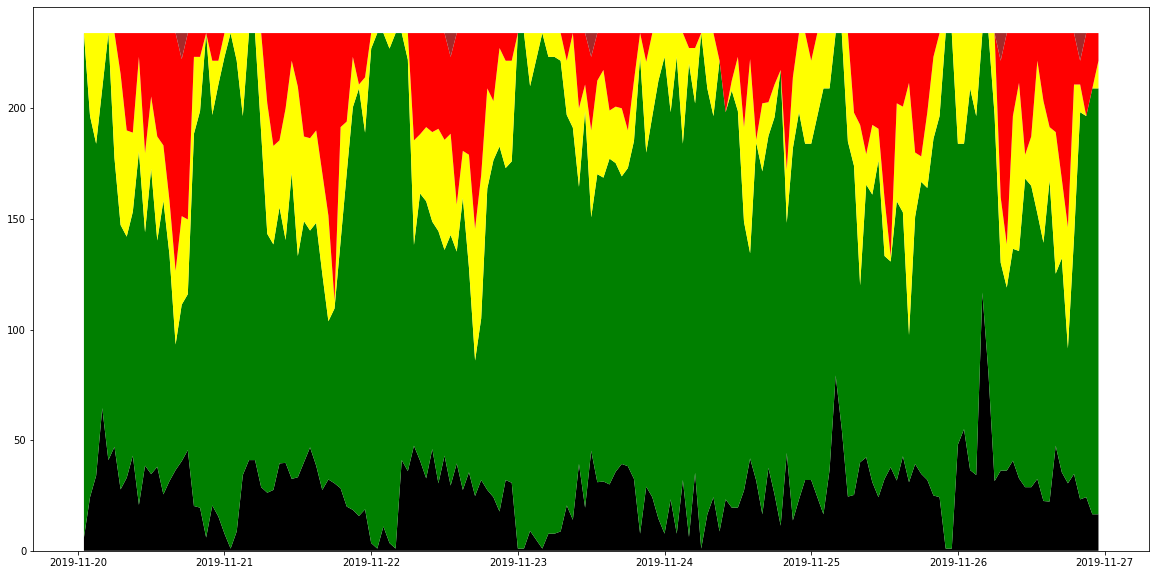

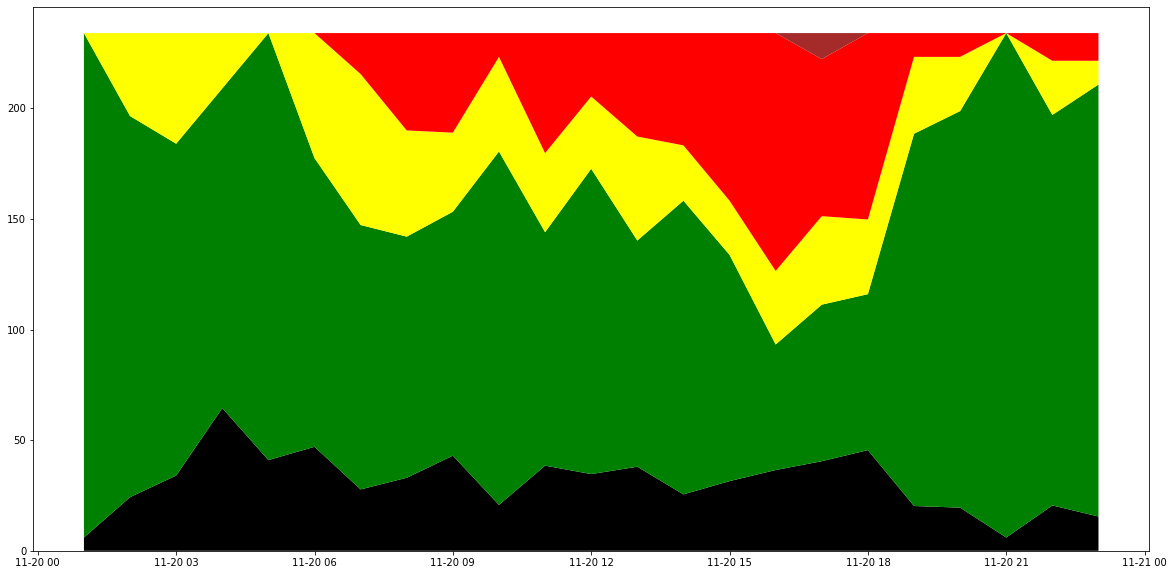

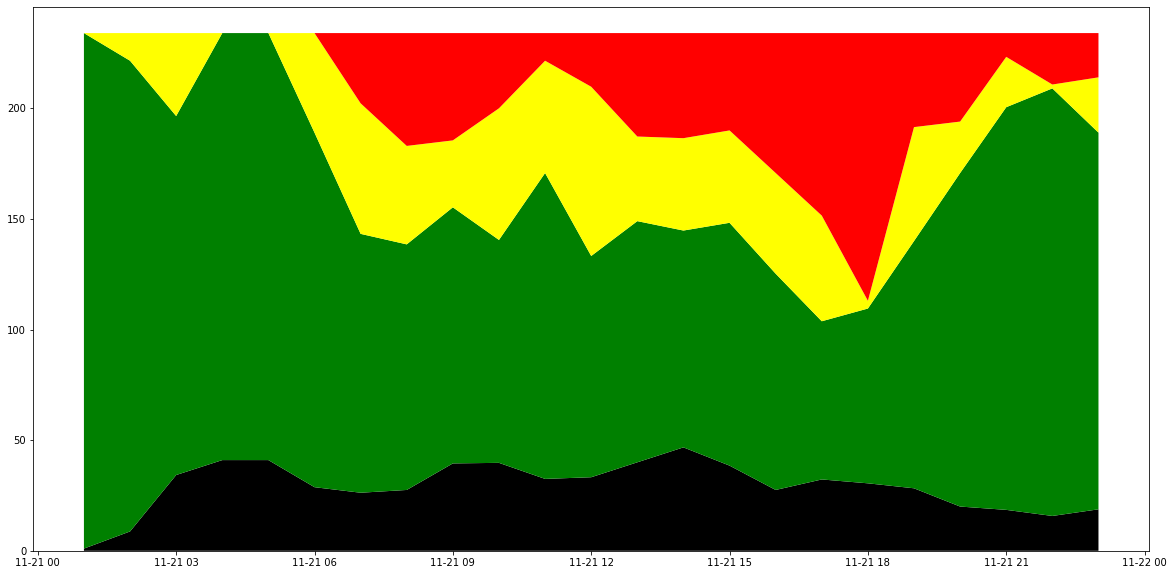

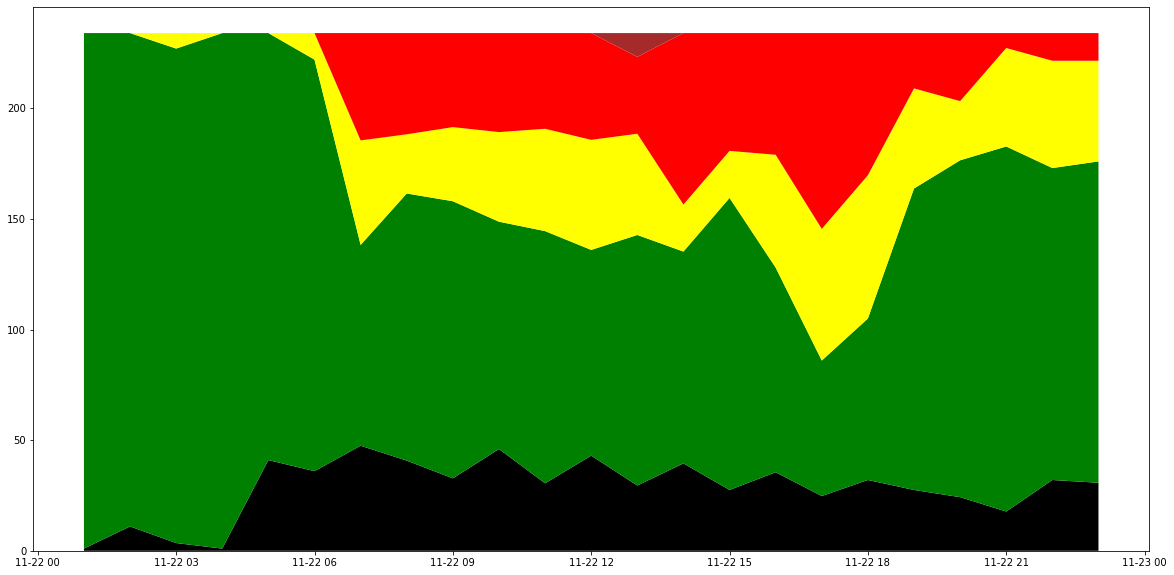

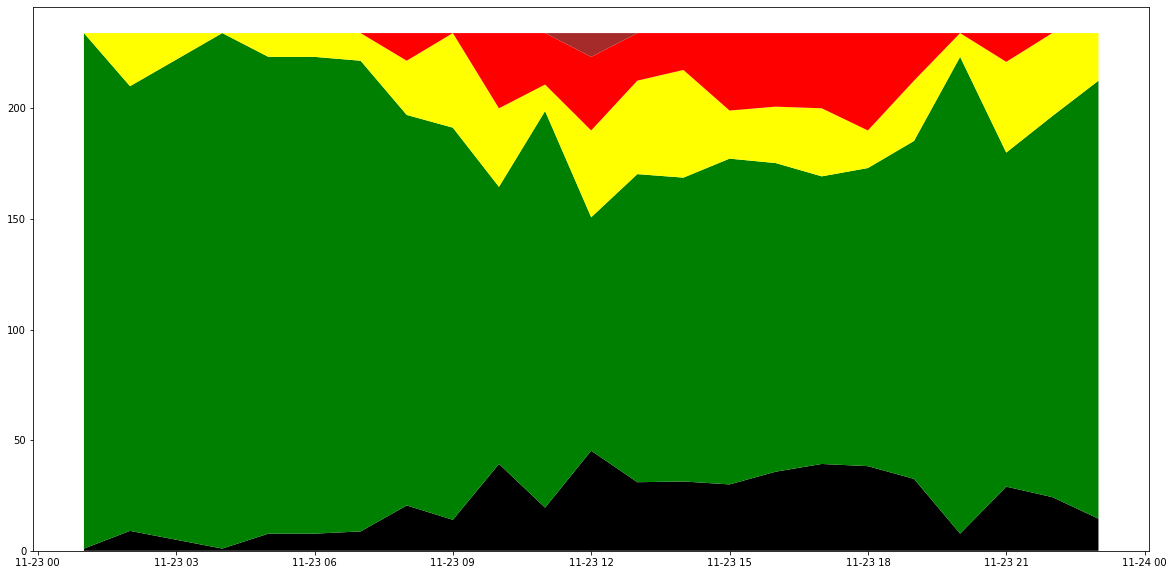

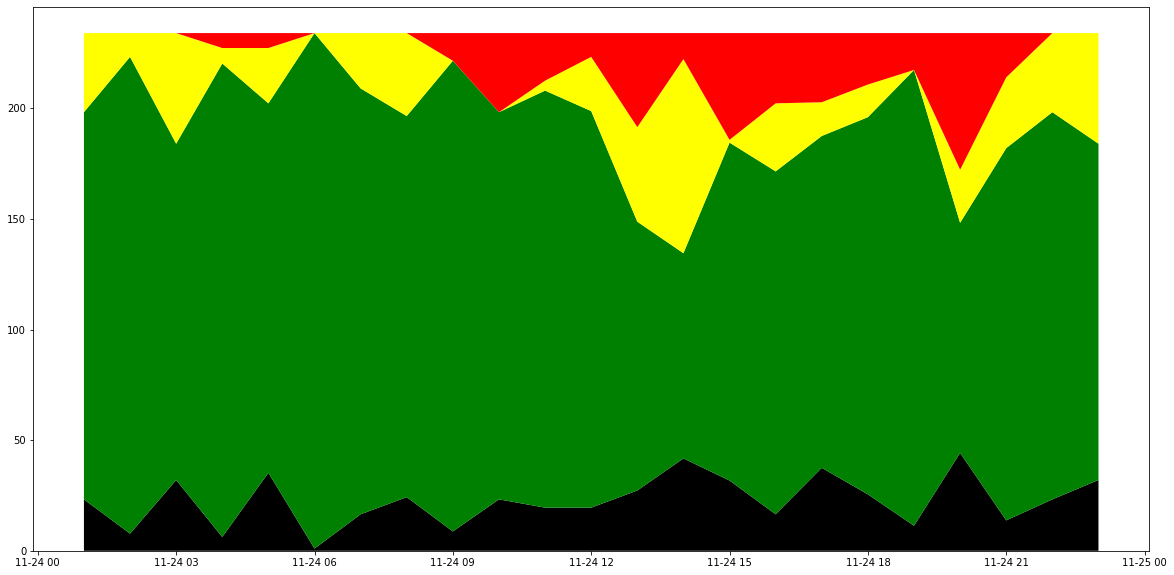

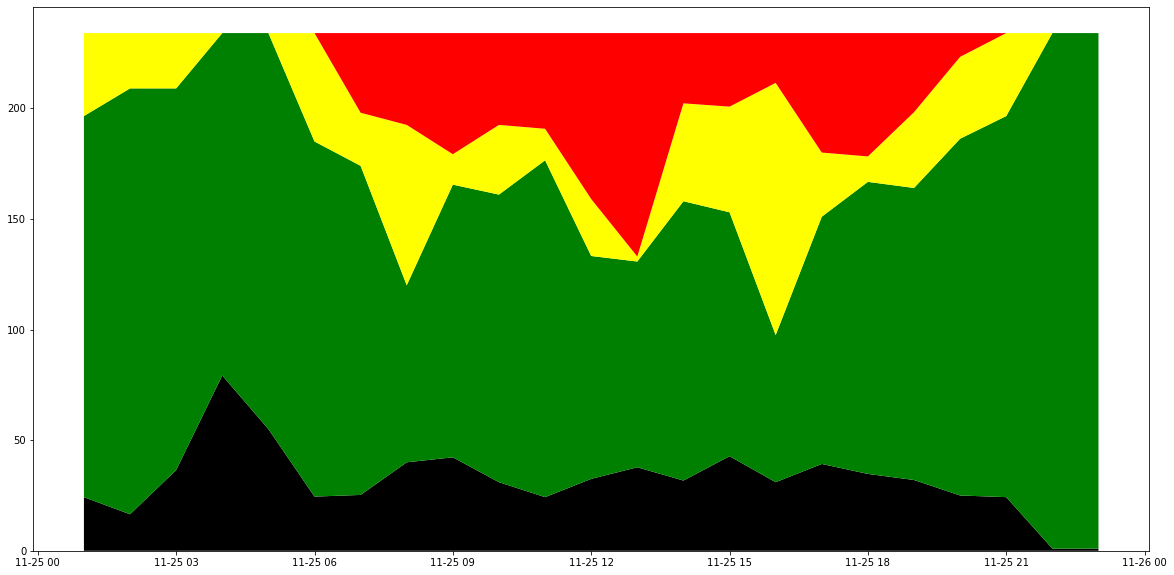

In [108]:
color_map=["black", "green", "yellow", "red", "brown"]

trafficDfCleanPlot = dataTraffic_sensor_overlap[(dataTraffic_sensor_overlap.index > datetime.datetime(year=2019,month=month,day=days[0])) & \
        (dataTraffic_sensor_overlap.index < datetime.datetime(year=2019,month=month,day=days[0]+len(days)))]

fig, ax = plt.subplots()
fig.set_size_inches(20, 10, forward=True)
ax.stackplot(trafficDfCleanPlot.index, trafficDfCleanPlot["darkGreen"], trafficDfCleanPlot["green"], trafficDfCleanPlot["orange"], trafficDfCleanPlot["red"], trafficDfCleanPlot["brown"], colors = color_map)
fig.savefig(f'trafficModelOutput/trafficDfCleanPlot_{month}_{days[0]}-{days[0]+len(days)}.png')

for n,i in enumerate(days):
    trafficDfCleanPlot = dataTraffic_sensor_overlap[(dataTraffic_sensor_overlap.index > datetime.datetime(year=2019,month=month,day=i)) & \
        (dataTraffic_sensor_overlap.index < datetime.datetime(year=2019,month=month,day=i+1))]

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 10, forward=True)
    ax.stackplot(trafficDfCleanPlot.index, trafficDfCleanPlot["darkGreen"], trafficDfCleanPlot["green"], trafficDfCleanPlot["orange"], trafficDfCleanPlot["red"], trafficDfCleanPlot["brown"], colors = color_map)
    fig.savefig(f'trafficModelOutput/trafficDfCleanPlot_{month}_{i}.png')

Combine no2 dataframe and traffic dataframe

In [109]:
dataTrain = pd.concat([dataNO2_sensor_overlap, dataTraffic_sensor_overlap], sort=False, axis=1).dropna(subset=['no2', 'inPicture'])
dataTrain

NO  OZON   no2       lon        lat  inPicture  \
timestamp                                                               
2019-10-18 20:00:00  29.0   NaN  49.0  7.004605  50.962838        1.0   
2019-10-18 21:00:00   4.0   NaN  37.0  7.004605  50.962838        1.0   
2019-10-18 23:00:00   4.0   NaN  27.0  7.004605  50.962838        1.0   
2019-10-19 00:00:00   4.0   NaN  35.0  7.004605  50.962838        1.0   
2019-10-19 01:00:00   4.0   NaN  22.0  7.004605  50.962838        1.0   
...                   ...   ...   ...       ...        ...        ...   
2019-11-27 14:00:00  13.0   NaN  31.0  7.004605  50.962838        1.0   
2019-11-27 15:00:00  12.0   NaN  30.0  7.004605  50.962838        1.0   
2019-11-27 16:00:00  13.0   NaN  40.0  7.004605  50.962838        1.0   
2019-11-27 18:00:00   4.0   NaN  31.0  7.004605  50.962838        1.0   
2019-11-27 19:00:00   4.0   NaN  29.0  7.004605  50.962838        1.0   

                          green  orange    red  brown  pixelCounterSensor  \
timestamp                                                                   
2019-10-18 20:00:00  154.000000   25.50   0.00    0.0          179.500000   
2019-10-18 21:00:00  140.666667   17.00  17.00    0.0          174.666667   
2019-10-18 23:00:00  155.000000   25.50   0.00    0.0          180.500000   
2019-10-19 00:00:00  175.750000   12.75   0.00    0.0          188.500000   
2019-10-19 01:00:00  176.000000   12.75   0.00    0.0          188.750000   
...                         ...     ...    ...    ...                 ...   
2019-11-27 14:00:00  127.750000   37.00  33.25    0.0          198.000000   
2019-11-27 15:00:00   86.750000   53.75  62.50    0.0          203.000000   
2019-11-27 16:00:00   70.750000   40.75  88.50    0.0          200.000000   
2019-11-27 18:00:00   68.750000   19.25  98.50   13.5          200.000000   
2019-11-27 19:00:00  135.333333   19.00  43.00    0.0          197.333333   

                     pixelCounterPicture  darkGreen    rgreen   rorange  \
timestamp                                                                 
2019-10-18 20:00:00          1091.000000  54.500000  0.138882  0.025551   
2019-10-18 21:00:00          1040.666667  59.333333  0.132879  0.017206   
2019-10-18 23:00:00          1031.500000  53.500000  0.147908  0.026956   
2019-10-19 00:00:00          1097.250000  45.500000  0.158579  0.013309   
2019-10-19 01:00:00          1143.250000  45.250000  0.152289  0.012788   
...                                  ...        ...       ...       ...   
2019-11-27 14:00:00          1086.250000  36.000000  0.115947  0.035684   
2019-11-27 15:00:00          1025.750000  31.000000  0.082784  0.053003   
2019-11-27 16:00:00           965.750000  34.000000  0.073232  0.040370   
2019-11-27 18:00:00           906.750000  34.000000  0.070155  0.022971   
2019-11-27 19:00:00          1059.333333  36.666667  0.127272  0.018390   

                         rred    rbrown  rdarkGreen  
timestamp                                            
2019-10-18 20:00:00  0.000000  0.000000    0.051618  
2019-10-18 21:00:00  0.017914  0.000000    0.058963  
2019-10-18 23:00:00  0.000000  0.000000    0.053560  
2019-10-19 00:00:00  0.000000  0.000000    0.042762  
2019-10-19 01:00:00  0.000000  0.000000    0.040833  
...                       ...       ...         ...  
2019-11-27 14:00:00  0.030583  0.000000    0.034072  
2019-11-27 15:00:00  0.062568  0.000000    0.030582  
2019-11-27 16:00:00  0.094356  0.000000    0.035353  
2019-11-27 18:00:00  0.114182  0.016056    0.038493  
2019-11-27 19:00:00  0.040639  0.000000    0.034849  

[683 rows x 18 columns]

Show correlation of no2 with traffic data

In [110]:
dataTrain.corr()["no2"]

NO                     6.528385e-01
OZON                            NaN
no2                    1.000000e+00
lon                    4.814879e-05
lat                    6.737200e-17
inPicture                       NaN
green                 -3.569864e-01
orange                 2.389778e-01
red                    3.723312e-01
brown                  4.841555e-02
pixelCounterSensor    -6.764124e-02
pixelCounterPicture   -2.001963e-01
darkGreen              6.764124e-02
rgreen                -3.813295e-01
rorange                2.271941e-01
rred                   3.608009e-01
rbrown                 4.024447e-02
rdarkGreen             5.534554e-02
Name: no2, dtype: float64

Set input and output features

In [111]:
features = dataTrain[["rdarkGreen", "rgreen", "rorange", "rred", "rbrown"]].values
target = dataTrain["no2"]

Scale input features

In [112]:
scaler = MinMaxScaler()
featuresScaled = scaler.fit_transform(features)

Create train / test split

In [113]:
featuresTrain, featuresTest, targetTrain, targetTest = train_test_split(featuresScaled, target, test_size=0.1, shuffle=False)

Create model

In [114]:
epochs=20
batch=20
lr = 0.005

input1 = keras.Input((5,))
dense1 = keras.layers.Dense(10, activation="relu")(input1)
dense2 = keras.layers.Dense(5, activation="relu")(dense1)
output = keras.layers.Dense(1, activation="linear")(dense2)

model = tf.keras.Model(inputs=[input1], outputs=[output])
model.compile(optimizer=keras.optimizers.Adam(lr, decay=lr/epochs), loss="mse")

In [115]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 6         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


Train model

In [116]:
history = model.fit(featuresTrain, targetTrain, epochs=epochs, validation_split=0.1, batch_size=batch)
model.evaluate(featuresTest, targetTest)
prediction = model.predict(featuresTest)
predictionTrain = model.predict(featuresTrain)

Train on 552 samples, validate on 62 samples
Epoch 1/20
552/552 [==============================] - 1s 2ms/sample - loss: 1942.0262 - val_loss: 1766.9585
Epoch 2/20
552/552 [==============================] - 0s 378us/sample - loss: 1923.0189 - val_loss: 1731.4113
Epoch 3/20
552/552 [==============================] - 0s 235us/sample - loss: 1835.4068 - val_loss: 1585.9206
Epoch 4/20
552/552 [==============================] - 0s 302us/sample - loss: 1588.7385 - val_loss: 1253.2624
Epoch 5/20
552/552 [==============================] - 0s 174us/sample - loss: 1124.8959 - val_loss: 731.6563
Epoch 6/20
552/552 [==============================] - 0s 147us/sample - loss: 568.6906 - val_loss: 297.1047
Epoch 7/20
552/552 [==============================] - 0s 236us/sample - loss: 267.8554 - val_loss: 186.2182
Epoch 8/20
552/552 [==============================] - 0s 195us/sample - loss: 220.4480 - val_loss: 188.9551
Epoch 9/20
552/552 [==============================] - 0s 138us/sample - loss: 218.19

In [117]:
plt.plot(history.history["loss"])
plt.show()

Plot result

In [118]:
predictionTest = pd.Series(prediction.T[0], index=targetTest.index)

fig, ax = subplots()
targetTest.plot(figsize=(20,10), fontsize=20, ax=ax)
predictionTest.plot(figsize=(20,10), fontsize=20, ax=ax)
ax.set_title(sensorID, fontsize=25)

fig.savefig(f'trafficModelOutput/targetTest_predictionTest.png')

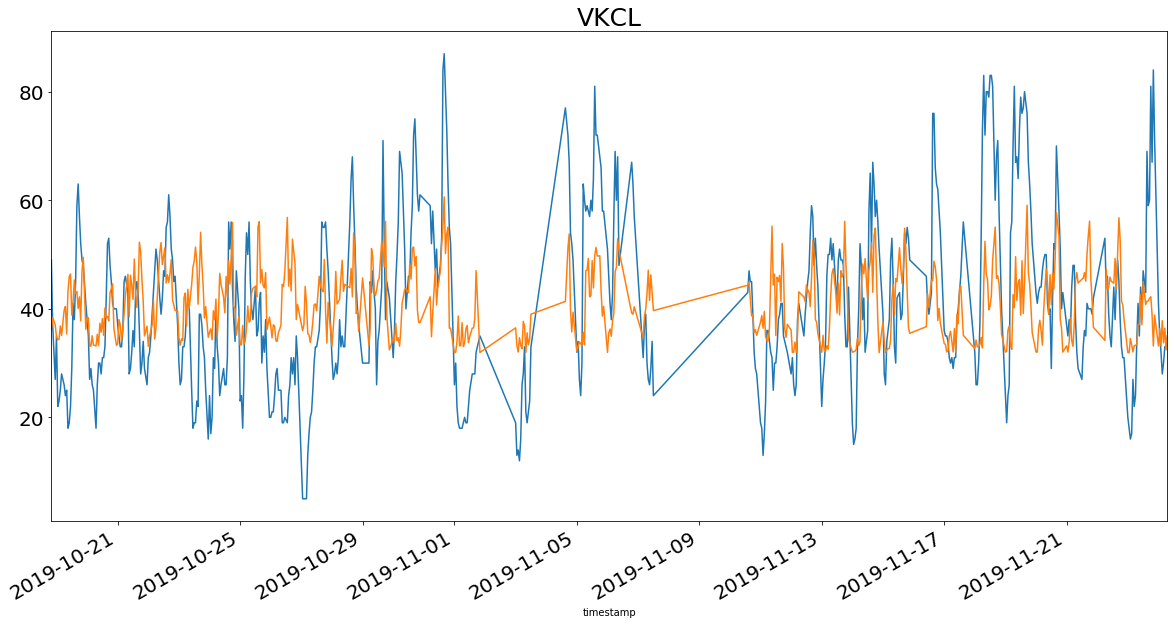

In [119]:
predictionTrain_series = pd.Series(predictionTrain.T[0], index=targetTrain.index)

fig, ax = subplots()
targetTrain.plot(figsize=(20,10), fontsize=20, ax=ax)
predictionTrain_series.plot(figsize=(20,10), fontsize=20, ax=ax)
ax.set_title(sensorID, fontsize=25)
fig.savefig(f'trafficModelOutput/targetTrain_predictionTrain.png')